## Poisson Regression Model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'
# ignore warnings
import warnings 
warnings.simplefilter('ignore')

The following cell generate data from

\begin{align*}
 & \mathrm{P}(y_i=y|x_{1i},x_{2i}) = \frac{e^{-\lambda_i}\lambda_i^y}{y!},\quad y=0,1,2,\dots, \\
 & \lambda_i = \exp(0.5 x_{1i} - 0.5 x_{2i}),\quad i=1,\dots,500.
\end{align*}


In [2]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
lam = np.exp(0.5*x1 - 0.5*x2)
y = st.poisson.rvs(lam)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
sim_param = dict([('$\\beta_{:d}$'.format(index), trace['b'][:, index]) for index in range(k)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


In [5]:
display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],0.042,0.049,-0.048,0.135,0.0,0.0,12927.0,12824.0,12917.0,14175.0,1.0
b[1],0.475,0.044,0.393,0.557,0.0,0.0,16201.0,16114.0,16217.0,13454.0,1.0
b[2],-0.510,0.043,-0.590,-0.430,0.0,0.0,16651.0,16593.0,16660.0,14431.0,1.0


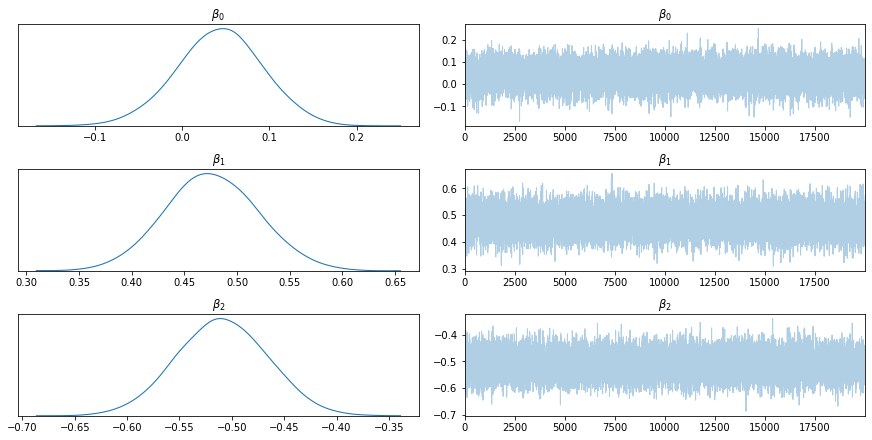

In [6]:
pm.traceplot(sim_param)
plt.show()

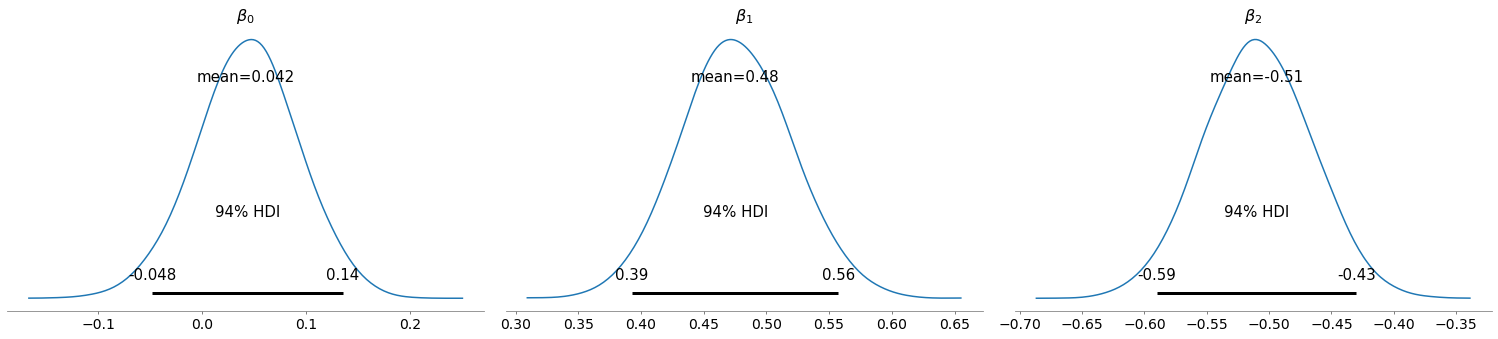

In [7]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()